<a href="https://colab.research.google.com/github/mjornada/objectDetection/blob/main/modeloMobilenetv3Large320.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import json
import torchvision
import torch
import torch.nn as nn
import torchvision.transforms as T
import os
import xml.etree.ElementTree as ET
from PIL import Image,ImageDraw
from IPython.display import display
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import numpy as np

In [ ]:
os.chdir('/content/drive/MyDrive')
!ls

'Colab Notebooks'	'Instruções P1 AL on line.pdf'
'covid (1).gsheet'	 modeloResnet.ipynb
 covid.csv		 objetos
 covid.gsheet		'Planilha sem título.gsheet'
 COVID.metadata.gsheet	 pulmoes
 datasets


In [ ]:
os.chdir('/content/drive/MyDrive/objetos')
!ls

20210701_202239.jpg    labels2.csv     labels.csv     objectDetection.ipynb
best_map_labelbox.pth  labels3.gsheet  labels.gsheet  __pycache__
imagens		       labels4.csv     mapeval.py


In [ ]:
from mapeval import voc_eval

In [ ]:
h_files = {}
with open('labels4.csv') as csv_file:
    for line in csv_file:
        v = line.split(',')
        class_att = v[0]
        x1,y1,x2,y2 = [int(x) for x in v[1:5]]
        img_file = v[5]
        if img_file not in h_files.keys():
            h_files[img_file] = {'boxes':[],'labels':[]}
        h_files[img_file]['boxes'].append((x1,y1,x2,y2)) 
        h_files[img_file]['labels'].append(class_att)

for img_file in h_files.keys():
    print(img_file)
    print(h_files[img_file]['boxes'])
    print(h_files[img_file]['labels'])

20210701_195955.jpg
[(1355, 864, 455, 369), (675, 522, 239, 329), (135, 950, 1053, 230), (383, 765, 792, 306), (1206, 711, 315, 108), (1350, 779, 639, 252), (1463, 612, 230, 252)]
['chaveiro', 'isqueiro', 'caneta', 'controle', 'pendrive', 'gaita', 'carro']
20210701_200012.jpg
[(914, 788, 243, 252), (563, 617, 248, 347), (1062, 1031, 315, 518), (500, 972, 459, 590), (302, 945, 198, 230), (1436, 1080, 581, 482), (1350, 882, 225, 216)]
['chaveiro', 'isqueiro', 'caneta', 'controle', 'pendrive', 'gaita', 'carro']
20210701_200016.jpg
[(761, 954, 212, 257), (396, 864, 225, 374), (1112, 1175, 833, 410), (815, 1157, 963, 630), (383, 1283, 351, 248), (1494, 1098, 662, 374), (1175, 990, 230, 176)]
['chaveiro', 'isqueiro', 'caneta', 'controle', 'pendrive', 'gaita', 'carro']
20210701_200025.jpg
[(1098, 864, 212, 216), (828, 711, 212, 293), (941, 1134, 261, 392), (360, 1004, 698, 455), (504, 968, 234, 144), (1301, 1166, 320, 414), (1422, 977, 221, 180)]
['chaveiro', 'isqueiro', 'caneta', 'controle',

In [ ]:
def resize(img,boxes,size):
    w, h = img.size
    ow, oh = size
    sw = float(ow) / w
    sh = float(oh) / h
    img = img.resize((ow,oh), Image.BILINEAR)
    boxes = boxes * torch.tensor([sw,sh,sw,sh])
    return img, boxes

In [ ]:
size = (300,300)
def transform_data(img,boxes):
    img,boxes = resize(img,boxes,size)
    img = T.Compose([
          T.ToTensor(), 
          T.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))          
    ])(img)
    return img,boxes

In [ ]:
class MyDataset():
    def __init__(self,transforms = None):
        self.data = []
        self.transforms = transforms
        self.target_names = ['blanck']
        self.htarget_names = {'blanck':0,'caneta':1,'carro':2, 'chaveiro':3,'controle':4, 'gaita':5,'isqueiro':6, 'pendrive':7}
        self.read_csv()

    def get_label_id(self,name):
        if name not in self.htarget_names:
            self.htarget_names[name] = len(self.target_names)
            self.target_names.append(name)
        return self.htarget_names[name]
    
    def read_csv(self):
        h_files = {}
        with open('labels4.csv') as csv_file:
            for line in csv_file:
                v = line.split(',')
                class_att = v[0]
                x1,y1,width,height = [int(x) for x in v[1:5]]
                x2 = x1 + width
                y2 = y1 + height
                img_file = v[5]
                if img_file not in h_files.keys():
                    h_files[img_file] = {'boxes':[],'labels':[]}
                h_files[img_file]['boxes'].append((x1,y1,x2,y2)) 
                h_files[img_file]['labels'].append(self.get_label_id(class_att))

        for img_file in h_files.keys():
            h = {}
            h['file_img'] = 'imagens/'+img_file
            h['labels'] = h_files[img_file]['labels']
            h['boxes']  = h_files[img_file]['boxes']
            self.data.append(h)


    def read_json(self):
        with open('labels4.json') as json_file:
            data = json.load(json_file)
            for h in data:
                if 'objects' in h['Label']:
                    file_url = h['Labeled Data']
                    file_name = 'imagens'+os.sep+h['External ID']
                    objects = h['Label']['objects']
                    boxes = []
                    labels = []
                    for obj in objects:
                        labels.append(self.get_label_id(obj['value']))
                        x1 = int(obj['bbox']['left'])
                        y1 = int(obj['bbox']['top'])
                        #x2 = int(obj['bbox']['width'])
                        #y2 = int(obj['bbox']['height'])
                        x2 = x1 + int(obj['bbox']['width'])
                        y2 = y1 + int(obj['bbox']['height'])
                        bbox  = [x1,y1,x2,y2]
                        boxes.append(bbox)
                    h = {}
                    h['file_img'] = file_name
                    h['labels'] = labels
                    h['boxes']  = boxes
                    self.data.append(h)
    def __getitem__(self,i):
        img   = Image.open(self.data[i]['file_img']).convert("RGB")
        boxes = torch.tensor(self.data[i]['boxes'])
        if self.transforms != None:
            img,boxes = self.transforms(img,boxes)
        r = dict()
        r['boxes']   = boxes
        r['labels']  = torch.tensor(self.data[i]['labels'])
        return img,r
    def __len__(self):
        return len(self.data)    

In [ ]:
data = MyDataset(transforms=transform_data)

In [ ]:
n = len(data)
n_treino = int(0.7*n)
n_teste  = n-n_treino
n_valid = int(0.2*n_treino)
n_treino = n_treino-n_valid

In [ ]:
n,n_treino,n_teste, n_valid

(199, 112, 60, 27)

In [ ]:
ds_treino,ds_teste,ds_valid = torch.utils.data.random_split(data,(n_treino,n_teste,n_valid))

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))
dl_treino = torch.utils.data.DataLoader(ds_treino,batch_size = 24,collate_fn=collate_fn)
dl_teste  = torch.utils.data.DataLoader(ds_teste,batch_size = 24,collate_fn=collate_fn)
dl_valid  = torch.utils.data.DataLoader(ds_valid,batch_size = 24,collate_fn=collate_fn)

In [ ]:
img,targets = next(iter(dl_treino))

In [ ]:
len(img)

24

In [ ]:
nview = Image.open(data.data[0]['file_img'])

In [ ]:
data.data[0]['boxes']

[(1355, 864, 1810, 1233),
 (675, 522, 914, 851),
 (135, 950, 1188, 1180),
 (383, 765, 1175, 1071),
 (1206, 711, 1521, 819),
 (1350, 779, 1989, 1031),
 (1463, 612, 1693, 864)]

In [ ]:
def draw_boxes(img,boxes,labels):
    imdraw = ImageDraw.Draw(img)
    for (box,label) in zip(boxes,labels):
        box = list(box)
        imdraw.rectangle(box,outline='red')
        text = "%d"%(label)
        imdraw.text((box[0],box[1]),text,fill='red')
    display(img)

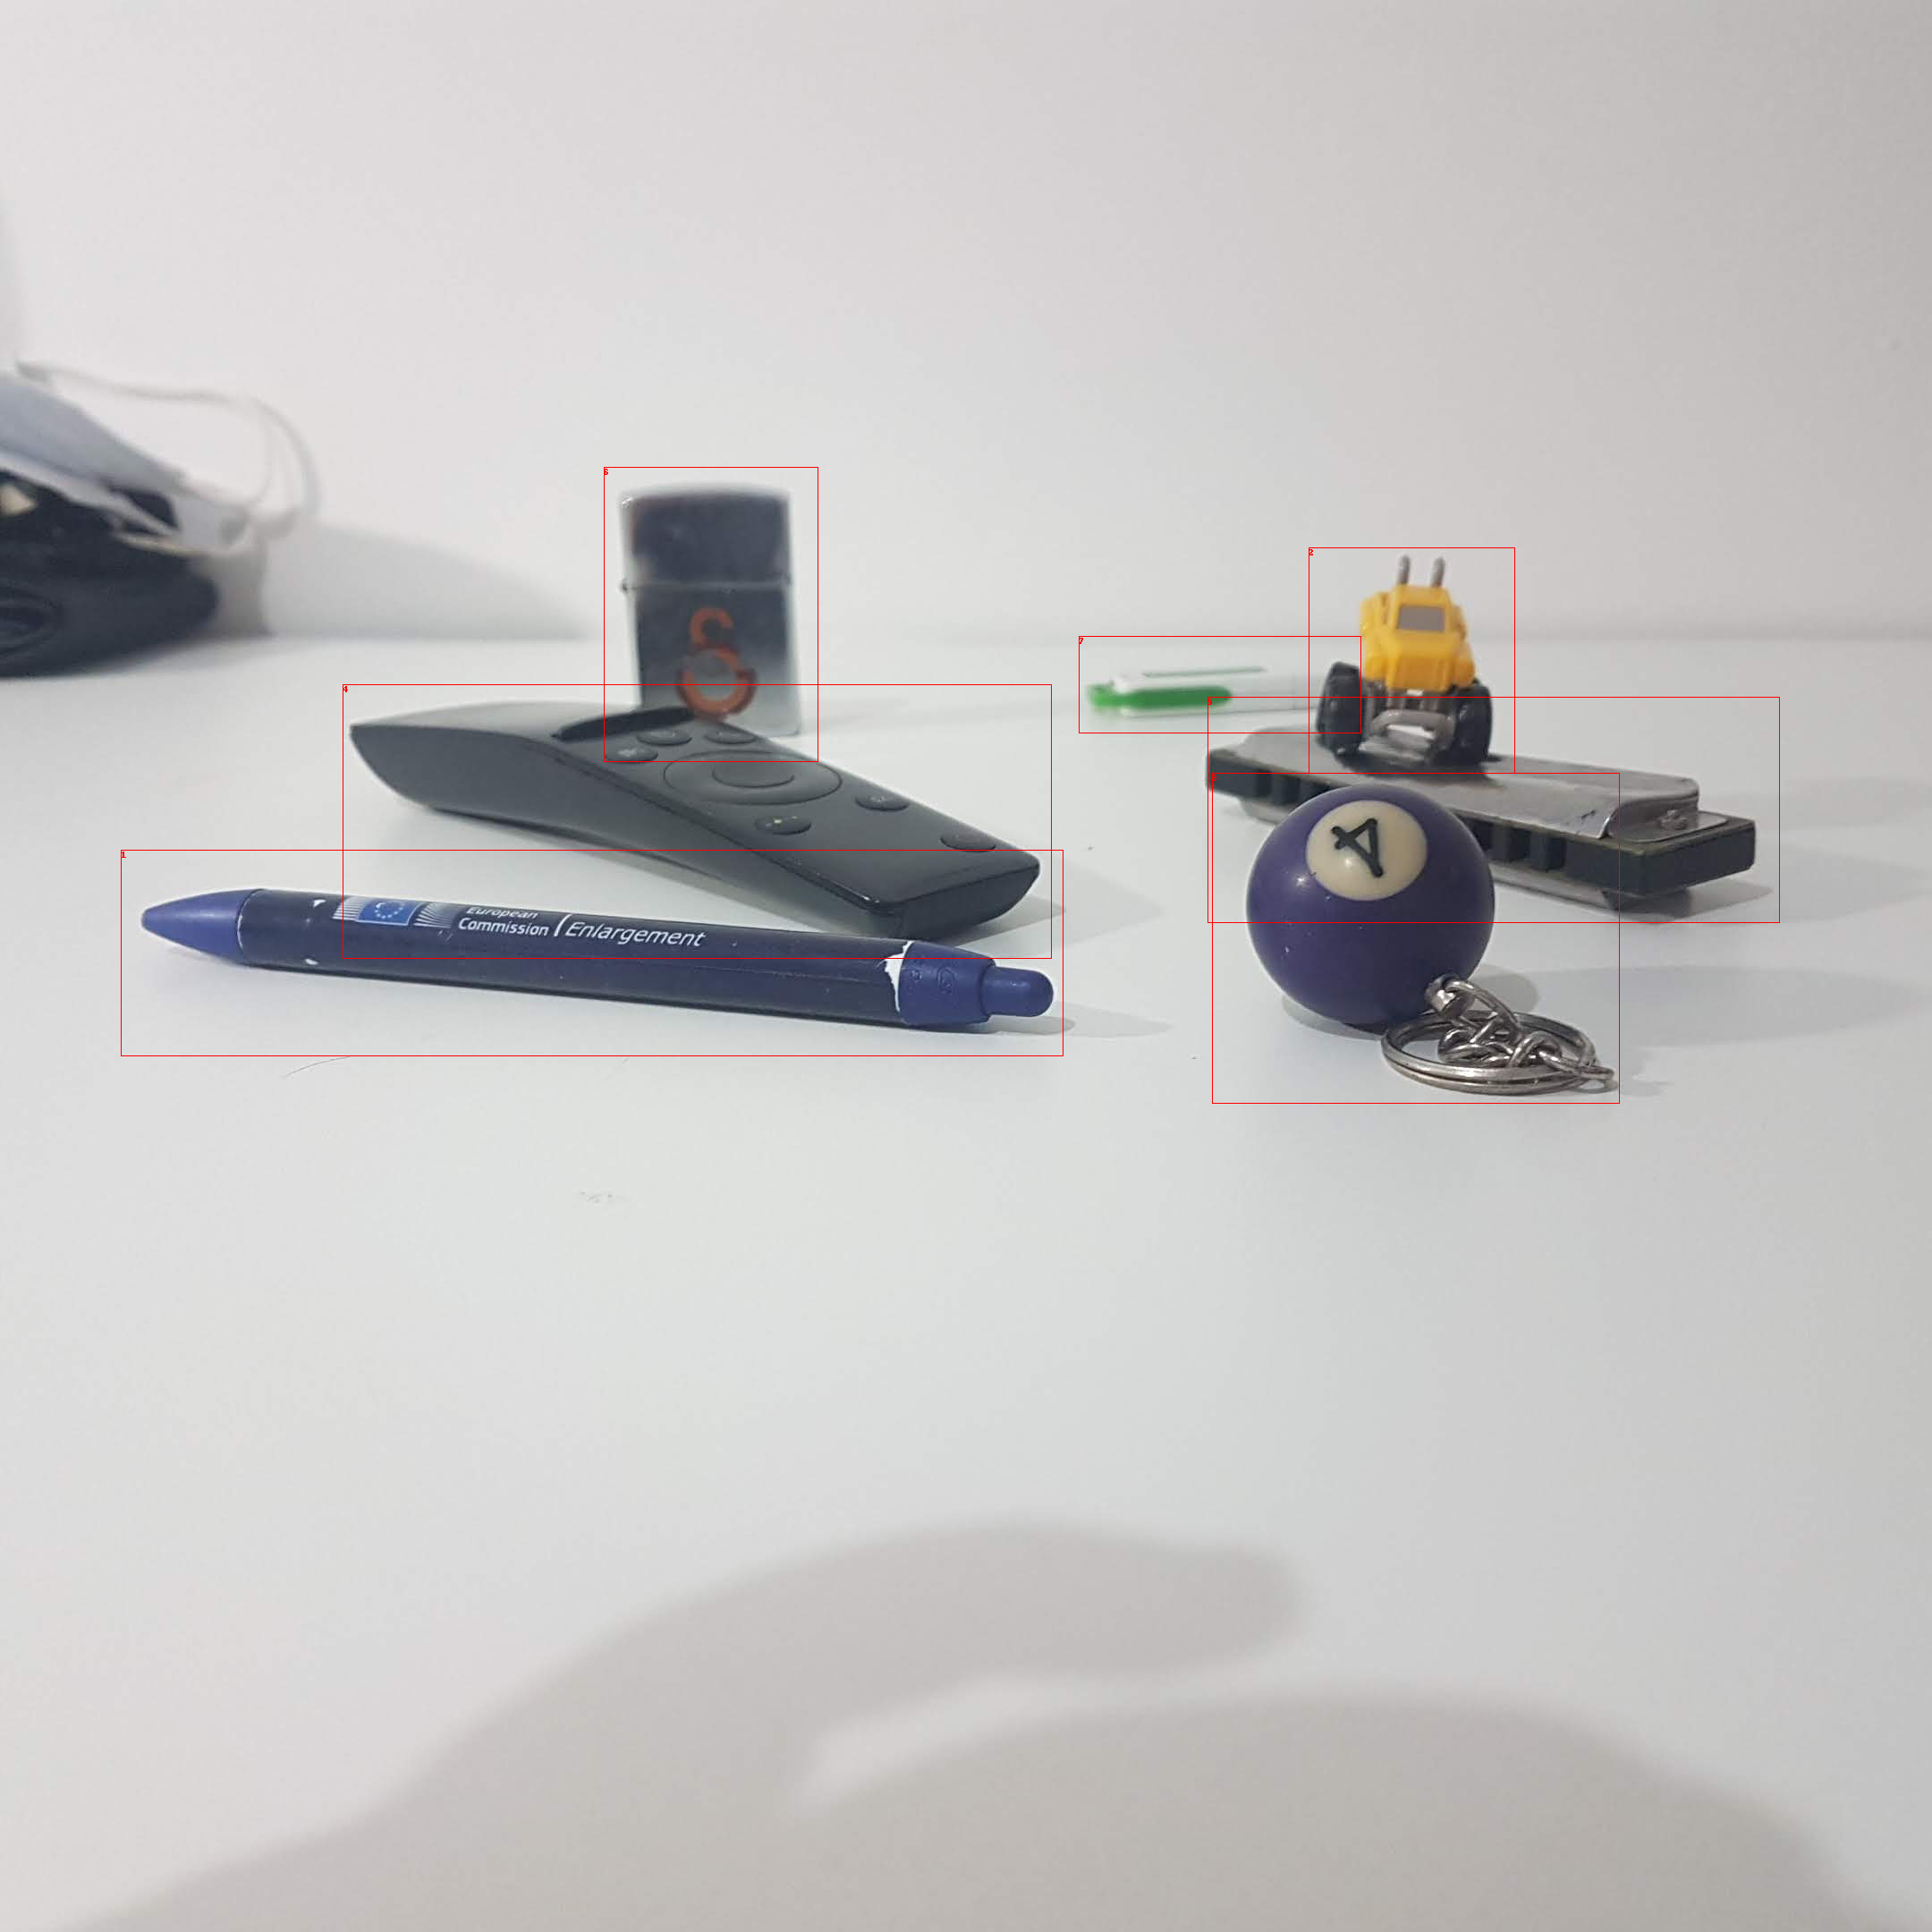

In [ ]:
draw_boxes(nview,data.data[0]['boxes'],data.data[0]['labels'])

In [ ]:
nview = T.ToPILImage()(img[0]*torch.Tensor([0.229,0.224,0.225]).view(3,1,1)+torch.Tensor([0.485,0.456,0.406]).view(3,1,1))

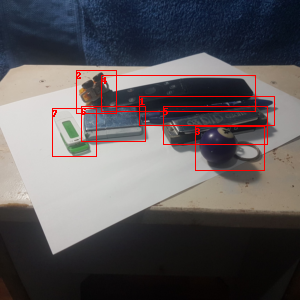

In [ ]:
draw_boxes(nview,targets[0]['boxes'],targets[0]['labels'])

In [ ]:
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True)

In [ ]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(320,), max_size=640, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): ConvBNActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): ConvBNActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): ConvBNActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): Identity()
          )
        )
      )
      (2): InvertedResidual(
 

In [ ]:
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features,8)

In [ ]:
opt = torch.optim.SGD(model.parameters(), lr=0.02, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt)

In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(320,), max_size=640, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): ConvBNActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): ConvBNActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): ConvBNActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): Identity()
          )
        )
      )
      (2): InvertedResidual(
 

In [ ]:
def train(epoch):
    model.train()
    bloss=[]
    for images,targets in dl_treino:
        images = list(image.to(device) for image in images)
        targets = [{k:v.to(device) for k,v in t.items()} for t in targets]
        
        loss_dict = model(images,targets)
        losses = sum(loss for loss in loss_dict.values())
        
        opt.zero_grad()
        losses.backward()
        opt.step()
        #print(loss_dict)
        #wlog = {}
        for loss in loss_dict.keys():
            print("%.10s %4.3f"%(loss,loss_dict[loss].item()))
        print("Total Loss %4.3f\n"%(losses))
        bloss.append(losses.item())
    
    print("\nEPOCH %d LR %5.5f\n"%(epoch,opt.param_groups[0]['lr']))

In [ ]:
def evaluate(epoch):
    model.eval()
    pred_boxes = []
    pred_labels = []
    pred_scores = []
    gt_boxes = []
    gt_labels = []
    lmap = []
    lap  = []
    with torch.no_grad():
        for images,targets in dl_teste:
            images = list(image.to(device) for image in images)
            pred   = model(images)
            for i in range(len(targets)):
                gt_boxes.append(targets[i]['boxes'])
                gt_labels.append(targets[i]['labels'])
                pred_boxes.append(pred[i]['boxes'].cpu())
                pred_labels.append(pred[i]['labels'].cpu())
                pred_scores.append(pred[i]['scores'].cpu())
                r = voc_eval(pred_boxes, pred_labels, pred_scores,
                gt_boxes, gt_labels)
                print(r)
                lmap.append(r['map'])
                #lap.append(r['ap'])
    print(np.mean(lmap))
    #print(np.mean(lap,axis=0))
    return np.mean(lmap)

In [ ]:
best_map = 0.0

In [ ]:
for epoch in range(10):
    train(epoch)
    map = evaluate(epoch)
    lr_scheduler.step(1.0-map)
    if map > best_map:
        best_map = map
        torch.save(model,'best_map_labelbox.pth')
        print('saving model')

loss_class  nan
loss_box_r  nan
loss_objec  nan
loss_rpn_b  nan
Total Loss  nan

loss_class  nan
loss_box_r  nan
loss_objec  nan
loss_rpn_b  nan
Total Loss  nan

loss_class  nan
loss_box_r  nan
loss_objec  nan
loss_rpn_b  nan
Total Loss  nan

loss_class  nan
loss_box_r  nan
loss_objec  nan
loss_rpn_b  nan
Total Loss  nan

loss_class  nan
loss_box_r  nan
loss_objec  nan
loss_rpn_b  nan
Total Loss  nan


EPOCH 0 LR 0.02000

{'ap': array([nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.]), 'map': 0.0}
{'ap': array([nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.]), 'map': 0.0}
{'ap': array([nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.]), 'map': 0.0}
{'ap': array([nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.]), 'map': 0.0}
{'ap': array([nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.]), 'map': 0.0}
{'ap': array([nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.]), 'map': 0.0}
{'ap': array([nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.]), 'map': 0.0}
{'ap': array([nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.]), 'map': 0.0}
{'ap': array([nan,  0.,  0.,  

In [ ]:
best_map

0.0

In [ ]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(320,), max_size=640, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (0): ConvBNActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): FrozenBatchNorm2d(16, eps=1e-05)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): ConvBNActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): ReLU(inplace=True)
          )
          (1): ConvBNActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(16, eps=1e-05)
            (2): Identity()
          )
        )
      )
      (2): InvertedResidual(
 